# LSTM을 이용한 주가 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

- Apple 주식 가격 예측

In [2]:
df = yf.download('AAPL', start='2000-01-01', end='2010-12-31', progress=False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,0.901228,0.918527,0.888393,0.917969,0.787035,163811200
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.856887,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.784643,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.796124,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.727229,767972800


- 주가 시각화

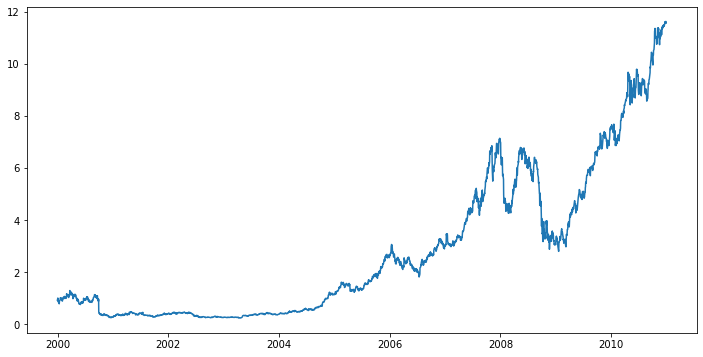

In [3]:
plt.figure(figsize=(12,6))
plt.plot(df["Close"],label='Close Price history')

- 종가만으로 단변수 선형회귀 

In [4]:
data = df.loc[:,['Close']]
data.head()

,Close
Date,
1999-12-31,0.917969
2000-01-03,0.999442
2000-01-04,0.915179
2000-01-05,0.928571
2000-01-06,0.848214


<!--  및 scaling -->

- train / valid set 분할 및 scaling

In [5]:
time = data.index
series = data.values

split_time = 2000

time_train = time[:split_time]
X_train = series[:split_time]

time_valid = time[split_time:]
X_valid = series[split_time:]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

X_train_scaled.shape, X_valid_scaled.shape

((2000, 1), (767, 1))

- tf.data.Dataset을 이용한 지도학습 data 생성 함수 작성

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

- training dataset 생성

In [7]:
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>


- model 생성 및 fitting

In [8]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(window_size,1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mse', optimizer='adam')

# lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)
lstm_model.fit(dataset, epochs=1, batch_size=1, verbose=2)

61/61 - 5s - loss: 0.1121 - 5s/epoch - 77ms/step


- valid set과 prediction 비교

In [9]:
inputs_data = data[len(data)-len(X_valid)-window_size:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

X_test = []
for i in range(window_size, inputs_data.shape[0]):
    X_test.append(inputs_data[i-window_size:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
prediction = lstm_model.predict(X_test)
prediction = scaler.inverse_transform(prediction)
prediction.shape

(767, 1)

- 시각화

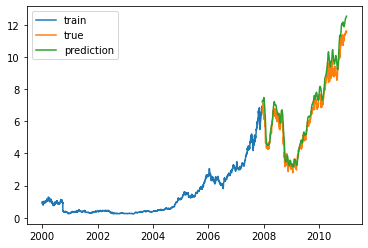

In [10]:
train_data = data[:-767]
valid_data = data[-767:]
valid_data['Predictions'] = prediction

plt.plot(train_data["Close"], label='train')
plt.plot(valid_data["Close"], label='true')
plt.plot(valid_data["Predictions"], label='prediction')

plt.legend()

- metric 비교

In [11]:
from sklearn.metrics import mean_squared_error
mean_squared_error(valid_data["Close"], valid_data["Predictions"])

0.28769486205778744

window_size tuning 
```
1 - 1.9269209847925197
2 - 0.3980598984612749
3 - 1.158177638455631
6 - 1.8811873612190408
30 - 0.5999837035140707
60 - 0.28769486205778744
```